# Permutation invariant Multi-output GPs

Now on to a complete application of all the individual pieces. That is, 
1. an LMC model, 
2. with an explicit covariance function over the outputs, and 
3. where each latent function is invariant to a permutation $\sigma(\{1,\ldots,p\})$ of its inputs.

I'll set this up like in the previous notebooks where we assume two groups in the LMC, with a suitably truncated eigen-decomp of the output covariance in each case. The first group will have a fairly large length scale, enforcing smoothly varying functions, while the second will have a short lengthscale to capture larger fluctuations. Each latent function will be invariant to a specific permutation of the inputs, and for simplicity I'll assume the functions have 4 inputs, and each latent function is invariant like so: $u(x_1,x_2,x_3,x_4)=u(x_2,x_1,x_3,x_4)$.

## Setting up simulation data

In [1]:
 # Code starts as before, with some imports and generating data
# Some imports
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import gpytorch
import numpy as np
import linear_operator
r = 2 # Number of latents
# Easiest way to sample from a GP using gpytorch?
# Setting up the grid
n = 11
x1 = torch.linspace(0,1,n)
x2 = torch.linspace(0,1,n)
x3 = torch.linspace(0,1,n)
x4 = torch.linspace(0,1,n)
x1_grid, x2_grid, x3_grid, x4_grid = torch.meshgrid(x1,x2,x3,x4,indexing='ij')
X1 = x1_grid.reshape(-1)
X2 = x2_grid.reshape(-1)
X3 = x3_grid.reshape(-1)
X4 = x4_grid.reshape(-1)
X = torch.stack([X1,X2,X3,X4],dim=-1)
X_flipped = torch.stack([X2,X1,X3,X4],dim=-1)

u1 = torch.zeros(X.size(dim=0),r)
u2 = torch.zeros(X.size(dim=0),r)

# Generating a random sample from a GP
mean1 = gpytorch.means.ZeroMean()
mean2 = gpytorch.means.ZeroMean()
kernel1 = gpytorch.kernels.RBFKernel()
kernel1.lengthscale = 1.5
kernel2 = gpytorch.kernels.RBFKernel()
kernel2.lengthscale = 0.2
m1 = mean1(X)
m2 = mean2(X)
K1 = (kernel1(X,X) + kernel1(X,X_flipped) + kernel1(X_flipped,X) + kernel1(X_flipped,X_flipped)).add_jitter(1e-2).evaluate()
K2 = (kernel2(X,X) + kernel2(X,X_flipped) + kernel2(X_flipped,X) + kernel2(X_flipped,X_flipped)).add_jitter(1e-2).evaluate()
for i in range(r):
    GP1 = gpytorch.distributions.MultivariateNormal(m1,K1)
    GP2 = gpytorch.distributions.MultivariateNormal(m2,K2)
    u1[:,i] = GP1.rsample().detach()
    u2[:,i] = GP2.rsample().detach()

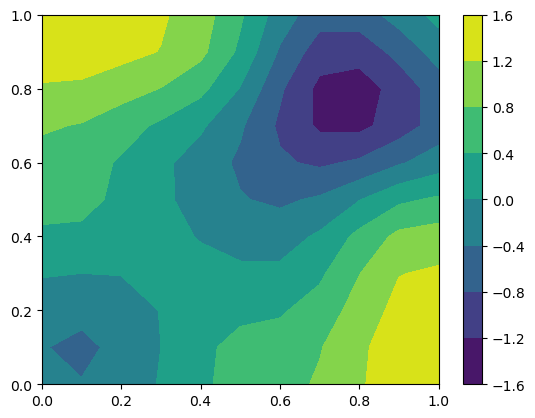

In [2]:
# Do plotting here so we don't generate a new sample everytime
# These plots should look symmetric
slice3 = 1
slice4 = 0
plt.contourf(x1_grid[:,:,slice3,slice4].numpy(),x2_grid[:,:,slice3,slice4].numpy(),u2[:,1].reshape(x1_grid.shape)[:,:,slice3,slice4])
plt.colorbar()

In [3]:
# Now creating outputs as linear combinations of these latent functions
# but now the lmc-parameters A is coming from another kernel over some covariates

m = 10 # num_outputs
covar_outputs1 = torch.cat([1+0.5*torch.randn(int(m/2.)),-1+0.5*torch.randn(int(m/2.))])
covar_outputs2 = torch.linspace(-1,1,m)
# These are just some really dumb covariates which will give some clustering structure
covar_kernel1 = gpytorch.kernels.RBFKernel()
covar_kernel1.lengthscale = 0.4
covar_kernel1 = covar_kernel1(covar_outputs1)
covar_kernel2 = gpytorch.kernels.PolynomialKernel(offset=0,power=2)
covar_kernel2 = covar_kernel2(covar_outputs2)
evals1, evecs1 = covar_kernel1.symeig(eigenvectors=True)
evecs1 = evecs1[:, -r:]
evals1 = linear_operator.operators.DiagLinearOperator(evals1[-r:])
A1 = evecs1.matmul(evals1.sqrt()).evaluate().detach()

evals2, evecs2 = covar_kernel2.symeig(eigenvectors=True)
evecs2 = evecs2[:, -r:]
evals2 = linear_operator.operators.DiagLinearOperator(evals2[-r:])
A2 = evecs2.matmul(evals2.sqrt()).evaluate().detach()

f = A1.matmul(u1.t()).t() + A2.matmul(u2.t()).t()
#for i in range(m):
#    plt.plot(x,f[:,i])
    
# Now generate some corresponding data
sigma = 0.01
y = f + sigma*torch.randn(f.size())

# Now going to get it ready for minibatching
from torch.utils.data import TensorDataset, DataLoader

# Get everything into long format
y_long = y.t().reshape(-1)
x_long = X.repeat(m,1)
task_indices = torch.arange(0,m).unsqueeze(1).repeat(1,n**4).reshape(-1).long()

# For last task, will remove some central observations 
#y_long[-5000:] = float('nan')
#x_long = x_long[~y_long.isnan()]
#task_indices = task_indices[~y_long.isnan()]
#y_long = y_long[~y_long.isnan()]

train_dataset = TensorDataset(x_long, y_long,task_indices)
train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)

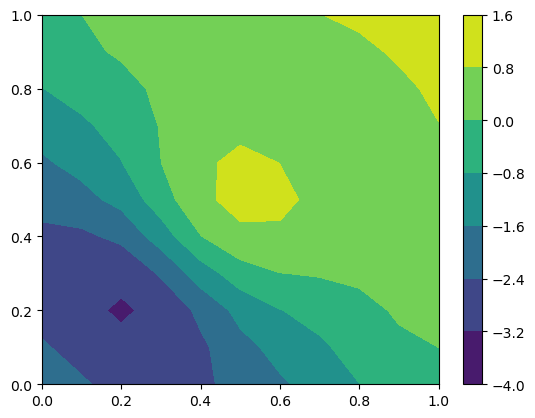

In [4]:
# Do plotting here so we don't generate a new sample everytime
# These plots should look symmetric
slice3 = 0
slice4 = 0
plt.contourf(x1_grid[:,:,slice3,slice4].numpy(),x2_grid[:,:,slice3,slice4].numpy(),f[:,9].reshape(x1_grid.shape)[:,:,slice3,slice4])
plt.colorbar()

## Set up the individual models

In [5]:
from synpred.variational.outputcovariance_lmc_variational_strategy import OutputCovarianceLMCVariationalStrategy
from synpred.variational.permutation_invariant_variational_strategy import PermutationInvariantVariationalStrategy

class ICM1(gpytorch.models.ApproximateGP):
    def __init__(self,output_covars):
        print("Init is run!")
        permutation = torch.tensor([1,0,2,3])
        # Different set of inducing points for each latent function
        inducing_points = torch.rand(r,700,4)
        # Same set of inducing points for each latent function
        #inducing_points = torch.linspace(0,1,30).unsqueeze(-1).repeat(r,1,1)
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each latent
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([r])
        )
        #variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
        #    inducing_points.size(-2), batch_shape=torch.Size([r])
        #)
        
        # Covariance over the outputs, and initialized by covariates
        output_kernel = gpytorch.kernels.RBFKernel()
        
        # We have to wrap the VariationalStrategy in a ModifiedLMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = OutputCovarianceLMCVariationalStrategy(
            PermutationInvariantVariationalStrategy(
                self, inducing_points, variational_distribution, 
                permutation=permutation,learn_inducing_locations=True
            ),
            output_kernel,
            output_covars,
            num_tasks=m,
            num_latents=r,
            latent_dim=-1
        )
        
        super(ICM1,self).__init__(variational_strategy)
        
        # The mean and covariance modules could be marked as batch
        # so we learn a different set of hyperparameters
        # For the ICM model, we do not set them as batch as we want the same kernel for each latent
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    


In [6]:
from synpred.variational.modified_lmc_variational_strategy import ModifiedLMCVariationalStrategy

class ICM2(gpytorch.models.ApproximateGP):
    def __init__(self,output_covars):
        print("Init is run!")
        # Different set of inducing points for each latent function
        inducing_points = torch.rand(r,700,4)
        permutation = torch.tensor([1,0,2,3])
        # Same set of inducing points for each latent function
        #inducing_points = torch.linspace(0,1,30).unsqueeze(-1).repeat(r,1,1)
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each latent
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([r])
        )
        #variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
        #    inducing_points.size(-2), batch_shape=torch.Size([r])
        #)
        
        # Covariance over the outputs, and initialized by covariates
        output_kernel = gpytorch.kernels.PolynomialKernel(offset=0,power=2)
        
        # We have to wrap the VariationalStrategy in a ModifiedLMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = OutputCovarianceLMCVariationalStrategy(
            PermutationInvariantVariationalStrategy(
                self, inducing_points, variational_distribution, 
                permutation=permutation,learn_inducing_locations=True
            ),
            output_kernel,
            output_covars,
            num_tasks=m,
            num_latents=r,
            latent_dim=-1
        )
        
        super(ICM2,self).__init__(variational_strategy)
        
        # The mean and covariance modules could be marked as batch
        # so we learn a different set of hyperparameters
        # For the ICM model, we do not set them as batch as we want the same kernel for each latent
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [7]:
from synpred.variational.sum_variational_strategy import SumVariationalStrategy
from torch.nn import ModuleList

class LMC(gpytorch.models.ApproximateGP):
    def __init__(self,output_covars):
        model1 = ICM1(covar_outputs1)
        model2 = ICM2(covar_outputs2)
        
        # We have to wrap the VariationalStrategy in a ModifiedLMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = SumVariationalStrategy(ModuleList([model1,model2]))
        
        super(LMC,self).__init__(variational_strategy)
        
        # The mean and covariance modules could be marked as batch
        # so we learn a different set of hyperparameters
        # For the ICM model, we do not set them as batch as we want the same kernel for each latent
        #self.mean_module1 = gpytorch.means.ZeroMean()
        #self.covar_module1 = gpytorch.kernels.RBFKernel()
        
    def forward(self, x):
        print("is soemthing happening here?")
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        #mean_x = self.mean_module(x)
        #covar_x = self.covar_module(x)
        #return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        raise NotImplementedError


    
    

model = LMC(covar_outputs1)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

Init is run!
Init is run!


## Training the model

In [8]:
# this is for running the notebook in our testing framework
import os
import tqdm.notebook
num_epochs = 4 # Number of complete passes through the data


model.train()
likelihood.train()



variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=y_long.size(0), lr=0.01)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)



# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_long.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch, task_batch in minibatch_iter:
        variational_ngd_optimizer.zero_grad()
        hyperparameter_optimizer.zero_grad()
        output = model(x_batch,task_indices=task_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        variational_ngd_optimizer.step()
        hyperparameter_optimizer.step()
        

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/489 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(model.variational_strategy.models[0].covar_module.lengthscale)
print(model.variational_strategy.models[1].covar_module.lengthscale)


In [ ]:
n = 11
x1_test = torch.linspace(0,1,n)
x2_test = torch.linspace(0,1,n)
x3_test = torch.linspace(0,1,n)
x4_test = torch.linspace(0,1,n)
x1_test_grid, x2_test_grid, x3_test_grid, x4_test_grid = torch.meshgrid(x1_test,x2_test,x3_test,x4_test,indexing='ij')
X1_test = x1_test_grid.reshape(-1)
X2_test = x2_test_grid.reshape(-1)
X3_test = x3_test_grid.reshape(-1)
X4_test = x4_test_grid.reshape(-1)
X_test = torch.stack([X1_test,X2_test,X3_test,X4_test],dim=-1)
X_test_flipped = torch.stack([X2_test,X1_test,X3_test,X4_test],dim=-1)
test_indices = torch.arange(9,10).unsqueeze(1).repeat(1,n**4).reshape(-1).long() # Only predict 9th output

In [ ]:
# Set into eval mode
model.eval()
likelihood.eval()
# Make predictions

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #predictions = likelihood(model(test_x,task_indices=test_indices,task_covars=newoutput))
    #predictions = likelihood(model(X_test,task_indices=test_indices))
    predictions = likelihood(model(X_test,task_indices=test_indices))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

In [ ]:
# Plotting 
# These plots should look symmetric
slice3 = 2
slice4 = 6
plt.contourf(x1_test_grid[:,:,slice3,slice4].numpy(),x2_test_grid[:,:,slice3,slice4].numpy(),mean.reshape(x1_test_grid.shape)[:,:,slice3,slice4])
plt.colorbar()
#plt.xlim(0,1)
#plt.ylim(0,1)
#plt.plot(model.variational_strategy.inducing_points.detach()[:,0],model.variational_strategy.inducing_points.detach()[:,1],'k*')

In [ ]:
# Compared with true function
slice3 = 2
slice4 = 6
plt.contourf(x1_grid[:,:,slice3,slice4].numpy(),x2_grid[:,:,slice3,slice4].numpy(),f[:,9].reshape(x1_grid.shape)[:,:,slice3,slice4])
plt.colorbar()

In [ ]:
# And look at the error surface
slice3 = 2
slice4 = 6
error = mean.reshape(x1_test_grid.shape)[:,:,slice3,slice4] - f[:,9].reshape(x1_grid.shape)[:,:,slice3,slice4]
plt.contourf(x1_grid[:,:,slice3,slice4].numpy(),x2_grid[:,:,slice3,slice4].numpy(),error)
plt.colorbar()

In [ ]:
A = model.variational_strategy.models[0].variational_strategy.lmc_coefficients.detach().t()
B = model.variational_strategy.models[1].variational_strategy.lmc_coefficients.detach().t()
plt.matshow(A.matmul(A.t()))
plt.matshow(B.matmul(B.t()))